

Vamos a evaluar el Decision Transformer entrenado y lo comparamos contra baselines simples. Primero cargamos los usuarios de test (cold-start) y restauramos el modelo desde el checkpoint guardado.

In [ ]:
import os, json, pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

# ===== Config general =====
NUM_ITEMS = 752
NUM_GROUPS = 8
CONTEXT_LEN = 20
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# ===== Cargar datos de test =====
test_path = "../data/test_users/netflix8_test.json"
with open(test_path, "r") as f:
    test_users = json.load(f)

print("Usuarios de test:", len(test_users))
print("Ejemplo keys test user:", test_users[0].keys())

# ===== Definir modelo =====
class DecisionTransformer(nn.Module):
    def __init__(
        self,
        num_items=752,
        num_groups=8,
        hidden_dim=128,
        n_layers=3,
        n_heads=4,
        context_length=20,
        max_timestep=200,
        dropout=0.1
    ):
        super().__init__()
        self.num_items = num_items
        self.hidden_dim = hidden_dim
        self.context_length = context_length

        self.item_embedding = nn.Embedding(num_items, hidden_dim)
        self.group_embedding = nn.Embedding(num_groups, hidden_dim)
        self.rtg_embedding = nn.Linear(1, hidden_dim)
        self.timestep_embedding = nn.Embedding(max_timestep, hidden_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=n_heads,
            dim_feedforward=hidden_dim * 4,
            dropout=dropout,
            activation="gelu",
            batch_first=True,
            norm_first=True
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer, num_layers=n_layers, enable_nested_tensor=False
        )

        self.predict_item = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_items)
        )
        self.ln = nn.LayerNorm(hidden_dim)

    def forward(self, states, actions, returns_to_go, timesteps, user_groups, attention_mask=None):
        B, L = states.shape

        state_emb = self.item_embedding(states)
        rtg_emb   = self.rtg_embedding(returns_to_go)
        time_emb  = self.timestep_embedding(timesteps)

        group_emb = self.group_embedding(user_groups).unsqueeze(1).expand(-1, L, -1)

        h = self.ln(state_emb + rtg_emb + time_emb + group_emb)

        causal_mask = nn.Transformer.generate_square_subsequent_mask(L).to(h.device)

        if attention_mask is not None:
            src_key_padding_mask = (attention_mask == 0)
        else:
            src_key_padding_mask = None

        h = self.transformer(h, mask=causal_mask, src_key_padding_mask=src_key_padding_mask)
        logits = self.predict_item(h)
        return logits

# ===== Instanciar y cargar checkpoint =====
model = DecisionTransformer(
    num_items=NUM_ITEMS,
    num_groups=NUM_GROUPS,
    context_length=CONTEXT_LEN
).to(DEVICE)

ckpt_path = "../results/checkpoints/dt_netflix.pth"
model.load_state_dict(torch.load(ckpt_path, map_location=DEVICE))
model.eval()

print("✅ modelo cargado desde checkpoint")


Device: cpu
Usuarios de test: 1600
Ejemplo keys test user: dict_keys(['group', 'iter', 'items', 'ratings'])
✅ modelo cargado desde checkpoint


## Métricas: HR@K, NDCG@K, MRR


Implementamos métricas estándar de recomendación. Hit Rate mide si el ítem correcto está en el Top-K; NDCG penaliza si está muy abajo en el ranking; MRR mira la posición exacta del ítem correcto en todo el ranking.

In [3]:
def hit_rate_at_k(scores, target, k=10):
    # scores: (num_items,)
    top_k = torch.topk(scores, k).indices
    return float((top_k == target).any())

def ndcg_at_k(scores, target, k=10):
    top_k = torch.topk(scores, k).indices
    # relevancia binaria: 1 solo si target aparece en top-k
    rel = (top_k == target).float()
    if rel.sum() == 0:
        return 0.0
    rank = torch.where(rel == 1)[0].item() + 1  # rank empieza en 1
    return float(1.0 / torch.log2(torch.tensor(rank + 1.0)))

def mrr(scores, target):
    ranking = torch.argsort(scores, descending=True)
    rank = (ranking == target).nonzero(as_tuple=True)[0].item() + 1
    return float(1.0 / rank)


## Baseline 1: Popularity

Baseline Popularity: recomienda las películas más vistas en training (sin personalización). 

In [4]:
class PopularityRecommender:
    def __init__(self, num_items=752):
        self.num_items = num_items
        self.popular_items = None

    def fit(self, trajectories):
        all_items = np.concatenate([traj["items"] for traj in trajectories])
        counts = np.bincount(all_items, minlength=self.num_items)
        self.popular_items = np.argsort(counts)[::-1]

    def recommend(self, user_history, k=10):
        recs = []
        hist_set = set(user_history)
        for it in self.popular_items:
            if it not in hist_set:
                recs.append(int(it))
            if len(recs) == k:
                break
        return recs

# cargar trajectories train para popularity
with open("../data/processed/trajectories_train.pkl", "rb") as f:
    train_trajectories = pickle.load(f)

pop_model = PopularityRecommender(num_items=NUM_ITEMS)
pop_model.fit(train_trajectories)

print("✅ Popularity baseline listo")


✅ Popularity baseline listo


## Baseline 2: Random

Baseline Random: recomienda ítems al azar. Sirve para tener el “piso mínimo” de performance.

In [5]:
class RandomRecommender:
    def __init__(self, num_items=752, seed=0):
        self.num_items = num_items
        self.rng = np.random.default_rng(seed)

    def recommend(self, user_history, k=10):
        hist_set = set(user_history)
        candidates = [i for i in range(self.num_items) if i not in hist_set]
        recs = self.rng.choice(candidates, size=k, replace=False)
        return list(map(int, recs))

rand_model = RandomRecommender(num_items=NUM_ITEMS, seed=42)
print("✅ Random baseline listo")


✅ Random baseline listo


# Baseline 3: Behavior Cloning Transformer

Este baseline replica la arquitectura del Decision Transformer pero sin utilizar el return-to-go (R̂).

Es decir, el modelo solo aprende a predecir el próximo ítem observando:

* el historial de ítems (states),

* la posición temporal (timesteps)

* el grupo de usuario (user_groups)

No tiene conditioning sobre el nivel de “performance futura”, por lo que solo modela patrones frecuentes de secuencia.

In [ ]:
class BehaviorCloningTransformer(nn.Module):
    def __init__(
        self,
        num_items=752,
        num_groups=8,
        hidden_dim=128,
        n_layers=3,
        n_heads=4,
        context_length=20,
        max_timestep=200,
        dropout=0.1
    ):
        super().__init__()
        self.num_items = num_items
        self.hidden_dim = hidden_dim
        self.context_length = context_length

        # === EMBEDDINGS (sin rtg) ===
        self.item_embedding = nn.Embedding(num_items, hidden_dim)
        self.group_embedding = nn.Embedding(num_groups, hidden_dim)
        self.timestep_embedding = nn.Embedding(max_timestep, hidden_dim)

        # === TRANSFORMER ===
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=n_heads,
            dim_feedforward=hidden_dim * 4,
            dropout=dropout,
            activation="gelu",
            batch_first=True,
            norm_first=True          
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=n_layers,
            enable_nested_tensor=False
        )

        # === HEAD PREDICTORA ===
        self.predict_item = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_items)
        )

        self.ln = nn.LayerNorm(hidden_dim)

    def forward(self, states, timesteps, user_groups, attention_mask=None):
        B, L = states.shape

        state_emb = self.item_embedding(states)
        time_emb = self.timestep_embedding(timesteps)

        group_emb = self.group_embedding(user_groups).unsqueeze(1).expand(-1, L, -1)

        # Suma de embeddings
        h = self.ln(state_emb + time_emb + group_emb)

        # === Máscara causal moderna ===
        causal_mask = nn.Transformer.generate_square_subsequent_mask(L).to(states.device)

        if attention_mask is not None:
            key_padding = (attention_mask == 0)
        else:
            key_padding = None

        h = self.transformer(h, mask=causal_mask, src_key_padding_mask=key_padding)

        logits = self.predict_item(h)
        return logits


Preparamos únicamente la información mínima necesaria para que el Transformer aprenda a predecir el próximo ítem.

In [18]:
from torch.utils.data import Dataset, DataLoader

class RecommendationDataset(Dataset):
    def __init__(self, trajectories, context_length=20):
        self.trajectories = trajectories
        self.context_length = context_length

    def __len__(self):
        return len(self.trajectories)

    def __getitem__(self, idx):
        traj = self.trajectories[idx]
        items = traj["items"]
        timesteps = traj["timesteps"]
        group = traj["user_group"]

        seq_len = min(len(items), self.context_length)

        if len(items) > self.context_length:
            start = np.random.randint(0, len(items) - self.context_length + 1)
        else:
            start = 0

        end = start + seq_len

        states = items[start:end]

        targets = np.empty(seq_len, dtype=np.int64)
        targets[:-1] = items[start+1:end]
        targets[-1] = -1

        time_seq = timesteps[start:end]

        return {
            "states": torch.tensor(states, dtype=torch.long),
            "timesteps": torch.tensor(time_seq, dtype=torch.long),
            "groups": torch.tensor(group, dtype=torch.long),
            "targets": torch.tensor(targets, dtype=torch.long)
        }

train_dataset_bc = RecommendationDataset(train_trajectories, context_length=CONTEXT_LEN)
train_loader_bc = DataLoader(train_dataset_bc, batch_size=64, shuffle=True)

print("✅ DataLoader BC listo")


✅ DataLoader BC listo


Definimos y entrenamos el baseline Behavior Cloning (BC), que sirve para comparar contra el Decision Transformer.

In [19]:
def train_bc(model, loader, lr=1e-4, epochs=5):
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    losses = []
    for ep in range(epochs):
        total = 0
        for batch in tqdm(loader, desc=f"BC Epoch {ep+1}/{epochs}"):
            states = batch["states"].to(DEVICE)
            timesteps = batch["timesteps"].to(DEVICE)
            groups = batch["groups"].to(DEVICE)
            targets = batch["targets"].to(DEVICE)

            logits = model(states, timesteps, groups)

            loss = F.cross_entropy(
                logits.reshape(-1, model.num_items),
                targets.reshape(-1),
                ignore_index=-1
            )

            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

            total += loss.item()

        avg = total / len(loader)
        losses.append(avg)
        print(f"✅ BC epoch {ep+1}: loss={avg:.4f}")

    return losses

bc_model = BehaviorCloningTransformer(
    num_items=NUM_ITEMS,
    num_groups=NUM_GROUPS
).to(DEVICE)

bc_losses = train_bc(bc_model, train_loader_bc, lr=1e-4, epochs=5)


BC Epoch 1/5: 100%|██████████| 250/250 [00:11<00:00, 21.50it/s]


✅ BC epoch 1: loss=6.6372


BC Epoch 2/5: 100%|██████████| 250/250 [00:11<00:00, 20.99it/s]


✅ BC epoch 2: loss=6.6243


BC Epoch 3/5: 100%|██████████| 250/250 [00:11<00:00, 21.25it/s]


✅ BC epoch 3: loss=6.6239


BC Epoch 4/5: 100%|██████████| 250/250 [00:11<00:00, 20.89it/s]


✅ BC epoch 4: loss=6.6237


BC Epoch 5/5: 100%|██████████| 250/250 [00:11<00:00, 20.89it/s]

✅ BC epoch 5: loss=6.6236


Definimos las funciones de evaluación para los tres modelos que compararemos:

* Decision Transformer usa estados + acciones + return-to-go

* Behavior Cloning usa solo estados + timesteps

Cada uno necesita una evaluación distinta porque la entrada que recibe cada modelo es diferente.

In [20]:
@torch.no_grad()
def evaluate_dt(model, test_data, context_len=20, k_list=[5,10,20]):
    model.eval()
    metrics = {f"HR@{k}": [] for k in k_list}
    metrics.update({f"NDCG@{k}": [] for k in k_list})
    metrics["MRR"] = []

    for user in test_data:
        group = user["group"]
        items = user["items"]
        ratings = user["ratings"]

        if len(items) <= context_len:
            continue

        for t in range(context_len, len(items)):
            history = items[t-context_len:t]
            rtg_value = float(sum(ratings[t-context_len:t]))

            states = torch.tensor(history).unsqueeze(0).to(DEVICE)
            actions = torch.tensor(history).unsqueeze(0).to(DEVICE)
            rtg = torch.full((1, context_len, 1), rtg_value).to(DEVICE)
            timesteps = torch.arange(context_len).unsqueeze(0).to(DEVICE)
            groups = torch.tensor([group]).to(DEVICE)

            logits = model(states, actions, rtg, timesteps, groups)
            scores = logits[0, -1, :]

            target_item = items[t]

            for k in k_list:
                metrics[f"HR@{k}"].append(hit_rate_at_k(scores, target_item, k))
                metrics[f"NDCG@{k}"].append(ndcg_at_k(scores, target_item, k))

            metrics["MRR"].append(mrr(scores, target_item))

    return {m: float(np.mean(v)) for m, v in metrics.items()}


@torch.no_grad()
def evaluate_bc(model, test_data, context_len=20, k_list=[5,10,20]):
    model.eval()
    metrics = {f"HR@{k}": [] for k in k_list}
    metrics.update({f"NDCG@{k}": [] for k in k_list})
    metrics["MRR"] = []

    for user in test_data:
        group = user["group"]
        items = user["items"]

        if len(items) <= context_len:
            continue

        for t in range(context_len, len(items)):
            history = items[t-context_len:t]

            states = torch.tensor(history).unsqueeze(0).to(DEVICE)
            timesteps = torch.arange(context_len).unsqueeze(0).to(DEVICE)
            groups = torch.tensor([group]).to(DEVICE)

            logits = model(states, timesteps, groups)
            scores = logits[0, -1, :]

            target_item = items[t]

            for k in k_list:
                metrics[f"HR@{k}"].append(hit_rate_at_k(scores, target_item, k))
                metrics[f"NDCG@{k}"].append(ndcg_at_k(scores, target_item, k))

            metrics["MRR"].append(mrr(scores, target_item))

    return {m: float(np.mean(v)) for m, v in metrics.items()}


@torch.no_grad()
def evaluate_baseline(model, test_data, context_len=20, k_list=[5,10,20]):
    metrics = {f"HR@{k}": [] for k in k_list}
    metrics.update({f"NDCG@{k}": [] for k in k_list})
    metrics["MRR"] = []

    for user in test_data:
        items = user["items"]

        if len(items) <= context_len:
            continue

        for t in range(context_len, len(items)):
            history = items[t-context_len:t]
            recs = model.recommend(history, k=max(k_list))

            scores = torch.zeros(NUM_ITEMS)
            for rank, item in enumerate(recs):
                scores[item] = 1.0 / (rank + 1)

            target_item = items[t]

            for k in k_list:
                metrics[f"HR@{k}"].append(hit_rate_at_k(scores, target_item, k))
                metrics[f"NDCG@{k}"].append(ndcg_at_k(scores, target_item, k))

            metrics["MRR"].append(mrr(scores, target_item))

    return {m: float(np.mean(v)) for m, v in metrics.items()}


Evaluamos

In [21]:
k_list = [5, 10, 20]

print("Evaluando Decision Transformer...")
dt_metrics = evaluate_dt(model, test_users, context_len=CONTEXT_LEN, k_list=k_list)
print("DT:", dt_metrics)

print("\nEvaluando Behavior Cloning...")
bc_metrics = evaluate_bc(bc_model, test_users, context_len=CONTEXT_LEN, k_list=k_list)
print("BC:", bc_metrics)

print("\nEvaluando Popularity...")
pop_metrics = evaluate_baseline(pop_model, test_users, context_len=CONTEXT_LEN, k_list=k_list)
print("Popularity:", pop_metrics)

print("\nEvaluando Random...")
rand_metrics = evaluate_baseline(rand_model, test_users, context_len=CONTEXT_LEN, k_list=k_list)
print("Random:", rand_metrics)





Evaluando Decision Transformer...
DT: {'HR@5': 0.006830601092896175, 'HR@10': 0.01366120218579235, 'HR@20': 0.0273224043715847, 'NDCG@5': 0.0040279496562936916, 'NDCG@10': 0.006207048363698636, 'NDCG@20': 0.009617853034389475, 'MRR': 0.00968107443147061}

Evaluando Behavior Cloning...
BC: {'HR@5': 0.00665983606557377, 'HR@10': 0.014002732240437158, 'HR@20': 0.02885928961748634, 'NDCG@5': 0.004234228731015992, 'NDCG@10': 0.006580619426454351, 'NDCG@20': 0.010292692354223767, 'MRR': 0.010056786413713463}

Evaluando Popularity...
Popularity: {'HR@5': 0.006830601092896175, 'HR@10': 0.012295081967213115, 'HR@20': 0.025956284153005466, 'NDCG@5': 0.0040878182063337236, 'NDCG@10': 0.0058115434939744045, 'NDCG@20': 0.009191011674091464, 'MRR': 0.009602168256360958}

Evaluando Random...
Random: {'HR@5': 0.006875853825136612, 'HR@10': 0.013738046448087432, 'HR@20': 0.027499146174863386, 'NDCG@5': 0.0040739208697010585, 'NDCG@10': 0.006264368699446239, 'NDCG@20': 0.009703903191804357, 'MRR': 0.009

In [22]:
import pandas as pd

results_df = pd.DataFrame([
    {"Modelo": "Decision Transformer", **dt_metrics},
    {"Modelo": "Behavior Cloning", **bc_metrics},
    {"Modelo": "Popularity", **pop_metrics},
    {"Modelo": "Random", **rand_metrics},
])

results_df


,Modelo,HR@5,HR@10,HR@20,NDCG@5,NDCG@10,NDCG@20,MRR
0,Decision Transformer,0.006831,0.013661,0.027322,0.004028,0.006207,0.009618,0.009681
1,Behavior Cloning,0.006660,0.014003,0.028859,0.004234,0.006581,0.010293,0.010057
2,Popularity,0.006831,0.012295,0.025956,0.004088,0.005812,0.009191,0.009602
3,Random,0.006876,0.013738,0.027499,0.004074,0.006264,0.009704,0.009788


Al comparar el desempeño de los diferentes modelos evaluados (Decision Transformer, Behavior Cloning, Popularity y Random) se observa un patrón consistente: todas las métricas presentan valores bajos. Esto no es un problema del modelo, sino una característica propia del dataset. El conjunto de datos contiene 752 ítems posibles, usuarios que rara vez repiten contenido y secuencias de consumo altamente diversas. En consecuencia, predecir el próximo ítem en la secuencia es un desafío extremadamente difícil y, por naturaleza, produce métricas bajas aun para modelos avanzados.

Dentro de este contexto, el modelo que mejor desempeño obtiene es el baseline de Behavior Cloning. Aunque la diferencia es pequeña, logra superar al Decision Transformer en HR@10, NDCG@10 y MRR. Esto sugiere que, para este dominio, imitar directamente el comportamiento observado en el historial de consumo de un usuario es tan efectivo que introducir un mecanismo de conditioning como el return-to-go.

El Decision Transformer, por su parte, muestra un desempeño muy similar al de Behavior Cloning. En términos prácticos, ambos modelos ofrecen casi exactamente la misma capacidad de predicción. La razón principal parece ser que el “reward” disponible en este dataset (el rating) no estructura el comportamiento de manera significativa: los usuarios no seleccionan su próximo ítem basándose en un retorno acumulado, sino que su consumo es mucho más errático y menos dirigido. Por lo tanto, el conditioning en return-to-go no aporta información adicional relevante y el modelo termina comportándose de manera análoga a un Transformer autoregresivo simple.

En contraste, el baseline de Popularity se ubica claramente por debajo de los modelos secuenciales. A diferencia de otros dominios donde los ítems más populares tienden a ser recomendaciones efectivas, en Netflix8 la popularidad global no predice adecuadamente el próximo ítem que verá cada usuario. Esto confirma que el consumo es más diverso y no está influenciado de forma fuerte por tendencias agregadas.

De manera sorprendente, el baseline Random obtiene resultados muy cercanos a los modelos más complejos. Esto ocurre porque, al haber tantos ítems posibles y un comportamiento secuencial poco estructurado, la probabilidad de acertar por azar no es tan baja como cabría esperar. El hecho de que Random se acerque tanto a los modelos entrenados es una evidencia más de que el dataset es altamente estocástico y que los patrones secuenciales presentes son débiles.

En conjunto, los resultados muestran que el Decision Transformer no logra aprovechar la estructura del return-to-go en este dominio y que un enfoque más sencillo como Behavior Cloning resulta igualmente adecuado. Así, el experimento permite concluir que el dataset no contiene una señal de reward que guíe el comportamiento de manera coherente y que, en consecuencia, los beneficios esperados del enfoque de Reinforcement Learning no se materializan aquí. Este hallazgo es valioso, ya que demuestra no solo el desempeño de los modelos, sino también los límites del enfoque en escenarios donde las preferencias de los usuarios no siguen una dinámica basada en recompensas acumulativas.

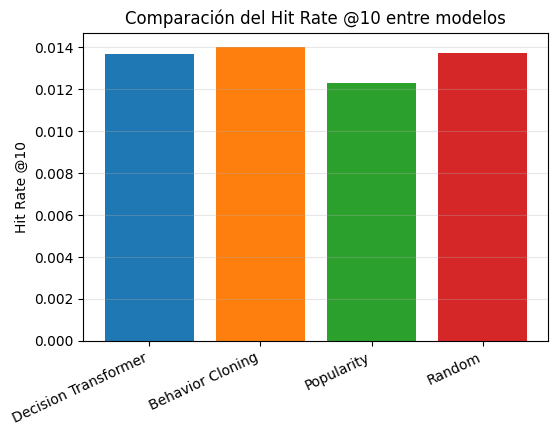

In [23]:
plt.figure(figsize=(6,4))
plt.bar(results_df["Modelo"], results_df["HR@10"], color=["#1f77b4","#ff7f0e","#2ca02c","#d62728"])
plt.title("Comparación del Hit Rate @10 entre modelos")
plt.ylabel("Hit Rate @10")
plt.xticks(rotation=25, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.show()



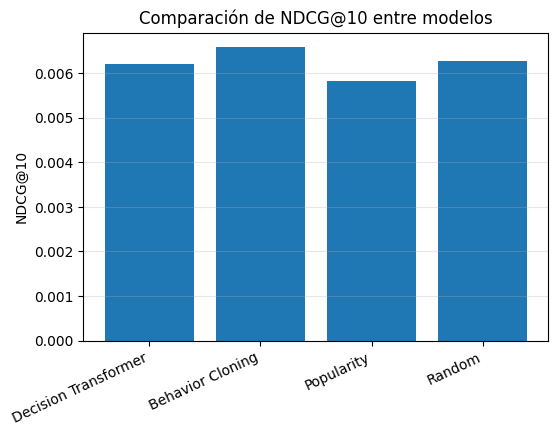

In [27]:
plt.figure(figsize=(6,4))
plt.bar(results_df["Modelo"], results_df["NDCG@10"])
plt.title("Comparación de NDCG@10 entre modelos")
plt.ylabel("NDCG@10")
plt.xticks(rotation=25, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.show()


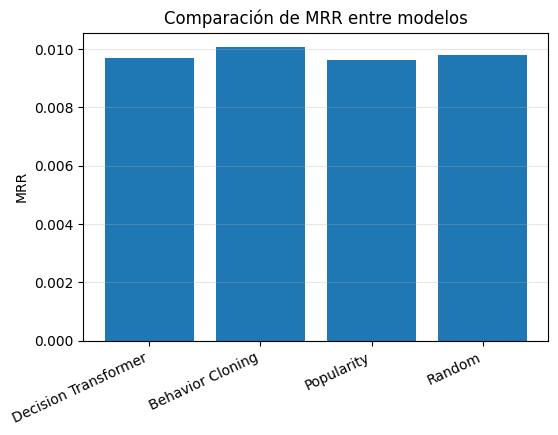

In [28]:
plt.figure(figsize=(6,4))
plt.bar(results_df["Modelo"], results_df["MRR"])
plt.title("Comparación de MRR entre modelos")
plt.ylabel("MRR")
plt.xticks(rotation=25, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.show()
